In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from sklearn.metrics import r2_score
from sklearn import preprocessing
#import scipy.io as sio

from models import VAE,AEBase
from models import DNN
import numpy as np
import pandas as pd
import models
import utils as ut
import copy

from scipy import stats


In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in M

In [2]:
from scipy.stats import pearsonr

# Parameters

In [3]:
# Define parameters
epochs = 500 #200,500,1000  
#dim_au_in = 20049
dim_au_out = 512 #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
select_drug = 'Gefitinib'
na = -1

# Import data

In [4]:
data_r=pd.read_csv('data/GDSCexpression.csv',index_col=0)
label_r=pd.read_csv('data/GDSClabel.csv',index_col=0)

In [5]:
label_r=label_r.fillna(na)

In [6]:
hvg,adata = ut.highly_variable_genes(data_r)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [7]:
label_r

,Erlotinib,AICAR,Camptothecin,Vinblastine,Cisplatin,Cytarabine,Docetaxel,Methotrexate,ATRA,Gefitinib,...,CMK,Pyrimethamine,JW-7-52-1,A-443654,GW843682X,MS-275,Parthenolide,MG-132,KIN001-135,TGX221
BxPC-3,-1.000000,0.159708,0.188393,0.436127,0.154274,0.113764,0.249987,0.015324,0.015324,0.020293,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
KMOE-2,0.002108,0.339814,0.318206,0.281740,0.063808,0.140681,0.101530,0.191210,0.031229,0.007419,...,0.022662,0.025217,0.270791,0.095608,0.139914,0.171747,0.026670,0.013904,0.002116,0.000956
MFM-223,0.002148,0.334087,0.122671,0.361438,0.051983,0.186659,0.228797,0.003639,0.023043,0.003639,...,0.038997,0.006167,0.002185,0.102592,0.020338,0.010874,0.000970,0.035206,0.007051,0.000323
NUGC-3,-1.000000,0.095099,0.416792,0.422631,0.266409,0.237811,0.234952,0.011558,0.028838,0.153002,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
OC-314,-1.000000,0.012740,0.479915,0.390145,0.067738,0.125869,0.249668,0.110418,0.002214,0.020309,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KP-N-S19s,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
BC-3,0.003515,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.048227,0.146476,0.400087,0.205247,0.147090,0.298803,0.023796,0.017219,0.002065,0.069181
Panc 08.13,-1.000000,0.152818,0.196279,0.180653,0.090963,0.093197,0.097267,0.018269,0.010237,0.009405,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
EKVX,0.177238,0.078395,0.078938,0.072213,0.007225,0.003470,0.129184,0.095642,0.111598,0.126364,...,0.020472,0.044047,0.243635,0.079375,0.019859,0.177759,0.014843,0.114431,0.007216,0.063911


In [8]:
selected_idx = label_r.loc[:,select_drug]!=na

In [9]:
data_r.columns = adata.var_names

# Your is gene-cell, mine is cell-gene

In [10]:
#data = data_r.loc[selected_idx,:]
data = data_r.loc[selected_idx,hvg]

In [11]:
label = label_r.loc[selected_idx,select_drug]
#sscaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
mmscaler = preprocessing.MinMaxScaler()
lbscaler = preprocessing.MinMaxScaler()

data = mmscaler.fit_transform(data)
label = lbscaler.fit_transform(label.values.reshape(-1,1))


In [12]:
print(np.std(data))
print(np.mean(data))

0.25383929199289434
0.2727100504700379


In [13]:
data.mean(axis=0)


array([0.49458949, 0.09860014, 0.21159545, ..., 0.21276445, 0.22738253,
       0.27747885])

In [14]:
print(data.max())
print(data.min())

1.0000000000000004
0.0


In [15]:
data.shape

(675, 3462)

In [16]:
label_r.shape

(789, 139)

# Split test train

In [17]:
from sklearn.model_selection import train_test_split
X_train_all, X_test, Y_train_all, Y_test = train_test_split(data, label, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all, Y_train_all, test_size=0.2, random_state=42)

In [18]:
print(data.shape)
print(label.shape)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(675, 3462)
(675, 1)
(432, 3462) (432, 1)
(135, 3462) (135, 1)


In [19]:
print(X_train.max())
print(X_train.min())

1.0000000000000002
0.0


# AE MODEL

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

cuda:0


# Add all data to AE

In [23]:
X_trainTensor = torch.FloatTensor(X_train).to(device)
X_validTensor = torch.FloatTensor(X_valid).to(device)
X_testTensor = torch.FloatTensor(X_test).to(device)
X_allTensor = torch.FloatTensor(data).to(device)
#X_alltrainTensor = torch.FloatTensor(X_train_all).to(device)


Y_trainTensor = torch.FloatTensor(Y_train).to(device)
Y_validTensor = torch.FloatTensor(Y_valid).to(device)

# construct TensorDataset
train_dataset = TensorDataset(X_trainTensor, X_trainTensor)
valid_dataset = TensorDataset(X_validTensor, X_validTensor)
test_dataset = TensorDataset(X_testTensor, X_testTensor)
all_dataset = TensorDataset(X_allTensor, X_allTensor)

X_trainDataLoader = DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)
X_validDataLoader = DataLoader(dataset=valid_dataset, batch_size=200, shuffle=True)
X_allDataLoader = DataLoader(dataset=all_dataset, batch_size=200, shuffle=True)

In [24]:
dataloader = X_trainDataLoader

In [25]:
dataloaders_train = {'train':X_trainDataLoader,'val':X_validDataLoader}

In [26]:
X_trainDataLoader.dataset.tensors[0].shape[0]

432

In [27]:
{x: dataloaders_train[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}

{'train': 432, 'val': 108}

# The model

In [28]:
model = AEBase(input_dim=data.shape[1],latent_dim=512,hidden_dims=[2048,1024])

In [29]:
print(model)

AEBase(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3462, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=1024, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=2048, out_features=3462, bias=True)
    (1): Sigmoid(

In [30]:
#model = VAE(dim_au_in=data_r.shape[1],dim_au_out=128)
if torch.cuda.is_available():
    model.cuda()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_function = nn.MSELoss()

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

In [31]:
def train_ae_model(net,data_loaders,optimizer,loss_function,n_epochs,scheduler):
    
    dataset_sizes = {x: data_loaders[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}
    loss_train = {}
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = np.inf

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizer = scheduler(optimizer, epoch)
                net.train()  # Set model to training mode
            else:
                net.eval()  # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            # for data in data_loaders[phase]:
            for batchidx, (x, _) in enumerate(data_loaders[phase]):

                x.requires_grad_(True)
                # encode and decode 
                output = model(x)
                # compute loss
                loss = loss_function(output, x)      

                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()

                # print loss statistics
                running_loss += loss.item()
            
            # Schedular
#             if phase == 'train':
#                 scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step(epoch_loss)
                
            last_lr = scheduler.optimizer.param_groups[0]['lr']
            loss_train[epoch,phase] = epoch_loss
            print('{} Loss: {:.8f}. Learning rate = {}'.format(phase, epoch_loss,last_lr))
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
    
    # Select best model wts
    torch.save(best_model_wts, 'saved/models/ae.pkl')
    net.load_state_dict(best_model_wts)           
    
    return net, loss_train

In [32]:
model,loss_report = train_ae_model(net=model,data_loaders=dataloaders_train,
                             optimizer=optimizer,loss_function=loss_function,
                            n_epochs=epochs,scheduler=exp_lr_scheduler)

Epoch 0/499
----------
train Loss: 0.00125573. Learning rate = 0.01
val Loss: 0.00170181. Learning rate = 0.01
Epoch 1/499
----------
train Loss: 0.00147174. Learning rate = 0.01
val Loss: 0.00177106. Learning rate = 0.01
Epoch 2/499
----------
train Loss: 0.00115337. Learning rate = 0.01
val Loss: 0.00177142. Learning rate = 0.01
Epoch 3/499
----------
train Loss: 0.00113844. Learning rate = 0.01
val Loss: 0.00179580. Learning rate = 0.01
Epoch 4/499
----------
train Loss: 0.00116946. Learning rate = 0.01
val Loss: 0.00179788. Learning rate = 0.01
Epoch 5/499
----------
train Loss: 0.00110736. Learning rate = 0.01
val Loss: 0.00181797. Learning rate = 0.01
Epoch 6/499
----------
train Loss: 0.00107485. Learning rate = 0.01
val Loss: 0.00175237. Learning rate = 0.01
Epoch 7/499
----------
train Loss: 0.00107800. Learning rate = 0.01
val Loss: 0.00163931. Learning rate = 0.01
Epoch 8/499
----------
train Loss: 0.00099224. Learning rate = 0.01
val Loss: 0.00155932. Learning rate = 0.01
E

train Loss: 0.00024959. Learning rate = 0.01
val Loss: 0.00028692. Learning rate = 0.01
Epoch 76/499
----------
train Loss: 0.00023145. Learning rate = 0.01
val Loss: 0.00031418. Learning rate = 0.01
Epoch 77/499
----------
train Loss: 0.00023662. Learning rate = 0.01
val Loss: 0.00030633. Learning rate = 0.01
Epoch 78/499
----------
train Loss: 0.00023198. Learning rate = 0.01
val Loss: 0.00028881. Learning rate = 0.01
Epoch 79/499
----------
train Loss: 0.00021755. Learning rate = 0.01
val Loss: 0.00028325. Learning rate = 0.01
Epoch 80/499
----------
train Loss: 0.00023826. Learning rate = 0.01
val Loss: 0.00027868. Learning rate = 0.01
Epoch 81/499
----------
train Loss: 0.00022479. Learning rate = 0.01
val Loss: 0.00028848. Learning rate = 0.01
Epoch 82/499
----------
train Loss: 0.00022879. Learning rate = 0.01
val Loss: 0.00028319. Learning rate = 0.01
Epoch 83/499
----------
train Loss: 0.00022038. Learning rate = 0.01
val Loss: 0.00027485. Learning rate = 0.01
Epoch 84/499
---

train Loss: 0.00017665. Learning rate = 0.01
val Loss: 0.00022776. Learning rate = 0.01
Epoch 150/499
----------
train Loss: 0.00017593. Learning rate = 0.01
val Loss: 0.00022644. Learning rate = 0.01
Epoch 151/499
----------
train Loss: 0.00016912. Learning rate = 0.01
val Loss: 0.00022550. Learning rate = 0.01
Epoch 152/499
----------
train Loss: 0.00016869. Learning rate = 0.01
val Loss: 0.00022487. Learning rate = 0.01
Epoch 153/499
----------
train Loss: 0.00016991. Learning rate = 0.01
val Loss: 0.00022444. Learning rate = 0.01
Epoch 154/499
----------
train Loss: 0.00016875. Learning rate = 0.01
val Loss: 0.00022409. Learning rate = 0.01
Epoch 155/499
----------
train Loss: 0.00017207. Learning rate = 0.01
val Loss: 0.00022329. Learning rate = 0.01
Epoch 156/499
----------
train Loss: 0.00016734. Learning rate = 0.01
val Loss: 0.00022447. Learning rate = 0.01
Epoch 157/499
----------
train Loss: 0.00017147. Learning rate = 0.01
val Loss: 0.00022398. Learning rate = 0.01
Epoch 15

train Loss: 0.00015386. Learning rate = 0.001
val Loss: 0.00021315. Learning rate = 0.001
Epoch 225/499
----------
train Loss: 0.00015441. Learning rate = 0.001
val Loss: 0.00021308. Learning rate = 0.001
Epoch 226/499
----------
train Loss: 0.00015421. Learning rate = 0.001
val Loss: 0.00021302. Learning rate = 0.001
Epoch 227/499
----------
train Loss: 0.00015631. Learning rate = 0.001
val Loss: 0.00021302. Learning rate = 0.001
Epoch 228/499
----------
train Loss: 0.00015300. Learning rate = 0.001
val Loss: 0.00021299. Learning rate = 0.001
Epoch 229/499
----------
train Loss: 0.00015594. Learning rate = 0.001
val Loss: 0.00021299. Learning rate = 0.001
Epoch 230/499
----------
train Loss: 0.00015588. Learning rate = 0.001
val Loss: 0.00021301. Learning rate = 0.001
Epoch 231/499
----------
train Loss: 0.00015385. Learning rate = 0.001
val Loss: 0.00021306. Learning rate = 0.001
Epoch 232/499
----------
train Loss: 0.00015426. Learning rate = 0.001
val Loss: 0.00021312. Learning rat

train Loss: 0.00015527. Learning rate = 1.0000000000000002e-07
val Loss: 0.00021267. Learning rate = 1.0000000000000002e-07
Epoch 294/499
----------
train Loss: 0.00015804. Learning rate = 1.0000000000000002e-07
val Loss: 0.00021266. Learning rate = 1.0000000000000002e-07
Epoch 295/499
----------
train Loss: 0.00015522. Learning rate = 1.0000000000000002e-07
val Loss: 0.00021267. Learning rate = 1.0000000000000002e-07
Epoch 296/499
----------
train Loss: 0.00015279. Learning rate = 1.0000000000000002e-07
val Loss: 0.00021270. Learning rate = 1.0000000000000002e-07
Epoch 297/499
----------
train Loss: 0.00015512. Learning rate = 1.0000000000000002e-07
val Loss: 0.00021274. Learning rate = 1.0000000000000002e-07
Epoch 298/499
----------
train Loss: 0.00015313. Learning rate = 1.0000000000000002e-07
val Loss: 0.00021274. Learning rate = 1.0000000000000002e-07
Epoch 299/499
----------
train Loss: 0.00015810. Learning rate = 1.0000000000000002e-07
val Loss: 0.00021269. Learning rate = 1.000

train Loss: 0.00015573. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021271. Learning rate = 1.0000000000000004e-08
Epoch 351/499
----------
train Loss: 0.00015288. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021275. Learning rate = 1.0000000000000004e-08
Epoch 352/499
----------
train Loss: 0.00015537. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021278. Learning rate = 1.0000000000000004e-08
Epoch 353/499
----------
train Loss: 0.00015313. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021274. Learning rate = 1.0000000000000004e-08
Epoch 354/499
----------
train Loss: 0.00015790. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021279. Learning rate = 1.0000000000000004e-08
Epoch 355/499
----------
train Loss: 0.00015637. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021272. Learning rate = 1.0000000000000004e-08
Epoch 356/499
----------
train Loss: 0.00015473. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021272. Learning rate = 1.000

train Loss: 0.00015270. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021286. Learning rate = 1.0000000000000004e-08
Epoch 408/499
----------
train Loss: 0.00015424. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021279. Learning rate = 1.0000000000000004e-08
Epoch 409/499
----------
train Loss: 0.00015392. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021274. Learning rate = 1.0000000000000004e-08
Epoch 410/499
----------
train Loss: 0.00015523. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021277. Learning rate = 1.0000000000000004e-08
Epoch 411/499
----------
train Loss: 0.00015449. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021273. Learning rate = 1.0000000000000004e-08
Epoch 412/499
----------
train Loss: 0.00015385. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021275. Learning rate = 1.0000000000000004e-08
Epoch 413/499
----------
train Loss: 0.00015640. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021280. Learning rate = 1.000

train Loss: 0.00015326. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021271. Learning rate = 1.0000000000000004e-08
Epoch 465/499
----------
train Loss: 0.00015672. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021267. Learning rate = 1.0000000000000004e-08
Epoch 466/499
----------
train Loss: 0.00015442. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021271. Learning rate = 1.0000000000000004e-08
Epoch 467/499
----------
train Loss: 0.00015429. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021276. Learning rate = 1.0000000000000004e-08
Epoch 468/499
----------
train Loss: 0.00015558. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021273. Learning rate = 1.0000000000000004e-08
Epoch 469/499
----------
train Loss: 0.00015728. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021269. Learning rate = 1.0000000000000004e-08
Epoch 470/499
----------
train Loss: 0.00015768. Learning rate = 1.0000000000000004e-08
val Loss: 0.00021272. Learning rate = 1.000

In [33]:
loss_report

{(0, 'train'): 0.001255725510418415,
 (0, 'val'): 0.0017018080861480147,
 (1, 'train'): 0.0014717425392181784,
 (1, 'val'): 0.0017710631644284284,
 (2, 'train'): 0.0011533666402101517,
 (2, 'val'): 0.0017714236897450905,
 (3, 'train'): 0.0011384358836544885,
 (3, 'val'): 0.001795803369195373,
 (4, 'train'): 0.001169462688267231,
 (4, 'val'): 0.001797884150787636,
 (5, 'train'): 0.0011073605812810085,
 (5, 'val'): 0.0018179716059455165,
 (6, 'train'): 0.001074853905097202,
 (6, 'val'): 0.0017523724171850416,
 (7, 'train'): 0.0010780031896299785,
 (7, 'val'): 0.0016393128920484472,
 (8, 'train'): 0.0009922447648865204,
 (8, 'val'): 0.0015593187676535712,
 (9, 'train'): 0.000996759747741399,
 (9, 'val'): 0.0013472308163289671,
 (10, 'train'): 0.001003672265344196,
 (10, 'val'): 0.0012247812140870977,
 (11, 'train'): 0.0009287677153393075,
 (11, 'val'): 0.0011734796894921197,
 (12, 'train'): 0.000972398694742609,
 (12, 'val'): 0.0011152502287317206,
 (13, 'train'): 0.0009316404315608519,
 

In [34]:
# # Old code for autoencoders
# for epoch in range(epochs):
#     # 不需要label，所以用一个占位符"_"代替
#     for batchidx, (x, _) in enumerate(X_allDataLoader):
#         x.requires_grad_(True)
#         # encode and decode 
#         output = model(x)
#         # compute loss
#         print(output.shape)
#         loss = loss_function(output, x)      
#         # update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
           
#     loss_train[epoch,0] = loss.item()  
#     print('Epoch: %04d, Training loss=%.8f' %
#           (epoch+1, loss.item()))

In [35]:
# torch.save(model.state_dict(), 'saved/models/ae.pkl')

In [36]:
recon_batch = model(X_trainTensor)

In [37]:
loss_function(recon_batch,X_trainTensor)

tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward>)

In [38]:
recon_batch

tensor([[0.4459, 0.0855, 0.1437,  ..., 0.1860, 0.1988, 0.3606],
        [0.5369, 0.0945, 0.1247,  ..., 0.3029, 0.2795, 0.2190],
        [0.0682, 0.4713, 0.0628,  ..., 0.1965, 0.3577, 0.2314],
        ...,
        [0.5083, 0.0900, 0.2943,  ..., 0.1654, 0.1806, 0.2451],
        [0.1801, 0.2435, 0.0931,  ..., 0.1933, 0.2778, 0.2916],
        [0.5959, 0.0741, 0.2252,  ..., 0.2214, 0.1905, 0.3547]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [39]:
X_trainTensor

tensor([[0.7359, 0.0868, 0.4233,  ..., 0.2414, 0.1303, 0.6761],
        [0.5435, 0.0496, 0.0739,  ..., 0.1036, 0.2022, 0.3589],
        [0.1336, 0.4184, 0.0618,  ..., 0.1218, 0.3170, 0.3572],
        ...,
        [0.3869, 0.0693, 0.4479,  ..., 0.2760, 0.2085, 0.0863],
        [0.1415, 0.0232, 0.0663,  ..., 0.2076, 0.3566, 0.3610],
        [0.6655, 0.0682, 0.3321,  ..., 0.2687, 0.1723, 0.2549]],
       device='cuda:0')

In [40]:
recon_batch.cpu().detach().numpy().min()

1.6604916e-09

In [41]:
train_embeddings = model.encode(X_trainTensor)

In [42]:
feature = train_embeddings.cpu().detach().numpy()

In [44]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.001)
clf.fit(feature, Y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5400536060333252, tolerance: 0.000920405553188175
  positive)


Lasso(alpha=0.001)

In [46]:
from sklearn.ensemble import RandomForestRegressor
RFrg = RandomForestRegressor(random_state=0, n_estimators=100)
RFrg.fit(feature, Y_train)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(random_state=0)

In [47]:
testFeature = model.encode(X_testTensor)
lasso = clf.predict(testFeature.detach().cpu().numpy())

In [48]:
rfresult = RFrg.predict(testFeature.detach().cpu().numpy())

In [56]:
from scipy import stats


In [49]:
r2_score(lasso,Y_test)

-5.634170333668802

In [63]:
stats.pearsonr(lasso,Y_test.flatten())

(0.3493415439054629, 3.283549013216569e-05)

In [50]:
r2_score(rfresult,Y_test)

-1.4088476103652297

In [64]:
stats.pearsonr(rfresult,Y_test.flatten())

(0.33695622558385663, 6.437302771182966e-05)

In [53]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.022s...
[t-SNE] Computed neighbors for 432 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 22.837967
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.346756
[t-SNE] KL divergence after 300 iterations: 0.438497


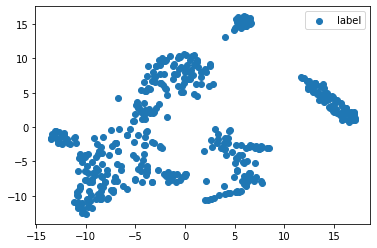

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label="label")
plt.legend()
plt.savefig("saved/figures/tsne_ae_gdsc.png")

In [ ]:
EPOCH = 500

In [ ]:
# Load data
# data type conversion
B_feature = torch.FloatTensor(feature).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
# construct TensorDataset
b_data = TensorDataset(B_feature, y)
trainDataLoader2 = DataLoader(dataset=b_data, batch_size=200, shuffle=False)

In [ ]:
# Initialization DNN model

predictor = DNN(128, dim_dnn_out).to(device)
optimizer = optim.Adam(predictor.parameters(), lr=1e-3,betas=(0.9,0.99))
#loss1-softmax
loss_func = nn.MSELoss().to(device)
#loss2-sigmoid
#loss_func = nn.BCELoss()
#loss3-sigmoid
#loss_func = nn.CrossEntropyLoss()

#criterion = torch.nn.MSELoss(size_average=True)
#criterion = torch.nn.BCELoss(size_average=True) # Defined loss function
#optimizer = optim.Adm(model.parameters(), lr=0.01) # Defined optimizer
loss_train = np.zeros((epochs, 1))

In [ ]:
# train model
for epoch in range(EPOCH):
    print('Epoch: ',epoch)
    for step,(batch_x,batch_y) in enumerate(trainDataLoader2):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        # predict label
        output = predictor(b_x)
        # b_y=F.sigmoid(b_y) 
        
        #print
        #print(output)
        #print(b_y)
        # compute loss
        loss = loss_func(output,b_y)
        #loss = criterion(output, b_y)
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item())) 

# Save model
torch.save(predictor.state_dict(), 'saved/models/DNN_GDSC.pkl')

In [ ]:
testpredict = predictor(testFeature)

In [ ]:
testpredict

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
r2_score(testpredict.detach().cpu().numpy(),Y_test)

In [ ]:
mean_squared_error(testpredict.detach().cpu().numpy(),Y_test)